# Inference

In [4]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from src.model import PatentSentenceClassifier
import matplotlib.pyplot as plt

In [5]:
# Load the checkpoint
checkpoint_name = 'bert-large-uncased_train_10_7'; model_name = "bert-large-uncased"
checkpoint_name = 'bert-for-patents_train_10_7'; model_name = "anferico/bert-for-patents"
checkpoint_path = f"/home/fantoni/patent-sentence-classification/models/finetuning/{checkpoint_name}.ckpt"

# Set hyperparameters
num_labels = 4

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Tokenizer and Base Model
bert_tokenizer = BertTokenizer.from_pretrained(model_name)
base_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
print('\nTokenizer and Base Model loaded succesfully.')

# Load Finetuned Patent Model
loaded_model = PatentSentenceClassifier.load_from_checkpoint(checkpoint_path, model=base_model, tokenizer=bert_tokenizer)
loaded_model.eval()
loaded_model.to(device)
print('\nModel loaded succesfully.')

Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at anferico/bert-for-patents and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Tokenizer and Base Model loaded succesfully.

Model loaded succesfully.



Sentence: 'If there are no allocated cells to a hub using the previous criterion, the first allocated cell will be the closest cell to that hub.'
Predicted Class: FUN
Probabilities: [0.69, 0.24, 0.04, 0.03]


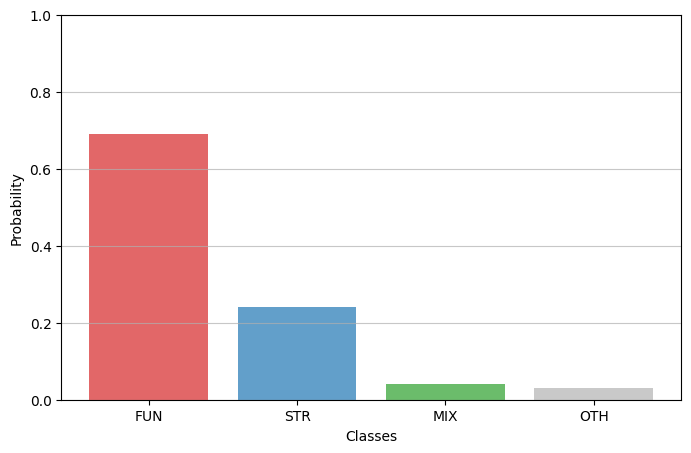

In [6]:
# Select Sentence
text_input = "Additionally, the stopper 108 is used at the distal end of the wire where the loop is formed to substantially secure the loop closed." # MIX
text_input = "Provisional Patent Application number 62/571,193; filed Oct. 11, 2017; and entitled INSECT VACUUM AND TRAP ATTACHMENT SYSTEMS." #OTH
text_input = "In some embodiments, the horizontal position of the idler support block 1213 may be adjustable to maintain tension on the chain 1212." #FUN
text_input = "The rigid foam layer 50 is typically selected from the group of polyurethane foams, polyurea foams, and combinations thereof." # STR
text_input = "If there are no allocated cells to a hub using the previous criterion, the first allocated cell will be the closest cell to that hub." #FUN

# Tokenize input
tokenizer = loaded_model.tokenizer  # Assuming tokenizer is part of the model
inputs = tokenizer(text_input, truncation=True, padding=True, max_length=512, return_tensors='pt')

# Perform inference on single sentence
inputs = {k: v.to(device) for k, v in inputs.items()}  # move input to same device
int_to_label = {0: 'FUN', 1: 'STR', 2: 'MIX', 3: 'OTH'}
with torch.no_grad():
    outputs = loaded_model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)

result = {
    'predicted_class': int_to_label[predicted_class.item()],
    'probabilities': [round(prob, 2) for prob in probabilities[0].tolist()]
}

# Visulize Inference on single sentence
print(f"\nSentence: '{text_input}'\nPredicted Class: {result['predicted_class']}\nProbabilities: {result['probabilities']}")
labels = list(int_to_label.values())
colors = ['#d62728', '#1f77b4', '#2ca02c', '#b2b2b2']  # Red, Blue, Green, Gray

# Plot the bar plot
plt.figure(figsize=(8, 5))
plt.bar(labels, result['probabilities'], color=colors, alpha=0.7)
plt.xlabel("Classes", fontsize=10)
plt.ylabel("Probability", fontsize=10)
plt.ylim(0, 1)  # Probabilities are between 0 and 1
plt.grid(axis='y', alpha=0.7)
plt.show()